In [ ]:
The pipeline of Mscale algorithm:
1. Autorefine the given original particle stack, based on this, reconstruct the density map raw.mrc and denoised.mrc
2. Calculate the amplitude attenuation scale factor scale
4. Scale Factor Scaling Denoising Grain Fourier rotationally averaged amplitudes
5. Save the scaled particle stack 


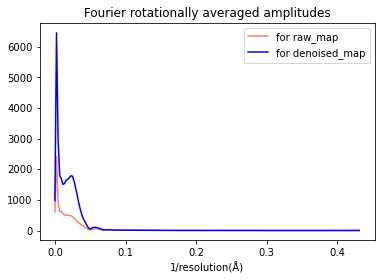

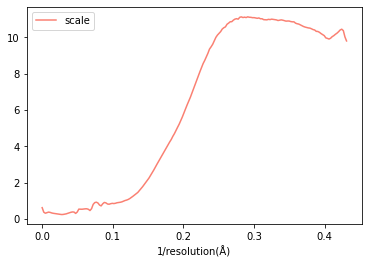

In [24]:
from EMAN2 import EMData, EMNumPy, Util, XYData, Region
import numpy as np
from sparx import get_image, binarize, model_square
import argparse, math, os, sys
import mrcfile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D




raw_map="./mrc/10616-raw.mrc" #import raw map
denoised_map='./mrc/10616-denoised.mrc' #import denoised map
apix=1.16 #pixel_size of raw/denoised map
box_size=384 #box size of raw/denoised map
r=box_size/2

# Function: compute Fourier rotationally averaged amplitudes(RAA) of map
def compute_map_radial_amplitude_distribution(map, apix):
    data = map.do_fft()    
    radial_average = data.calc_radial_dist(int(r), 0.0, 1.0, 0)
    return radial_average
# Function: compute Fourier rotationally averaged amplitudes(RAA) of micrograph
def compute_mrc_radial_amplitude_distribution(mrc, apix):
    data = mrc.do_fft()    
    radial_average = data.calc_radial_dist(int(r), 0.0, 1.0, 0)
    return radial_average

# Function: scale amplitudes of the denoised particles with the scale rate:
def scale_denoised_amp(mrc, scale, apix):
    data = mrc.do_fft()
    emrc_radial_average=compute_mrc_radial_amplitude_distribution(mrc,apix)
    scaled_distribution= np.ndarray.tolist(np.asarray(emrc_radial_average)*scale)
    frequency_range = np.arange(0, (1 / (2 * apix)), (1.0 / (apix * mrc.get_xsize())))
    frequency_range = np.ndarray.tolist(frequency_range[0:len(scaled_distribution)])
    sf = XYData()
    sf.set_xy_list(frequency_range, scaled_distribution)
    data.process_inplace("filter.setstrucfac", {"apix":apix, "strucfac":sf})
    mrc = data.do_ift()
    return mrc

rawmap= get_image(raw_map)
demap =get_image(denoised_map)
raw_amp_average=compute_map_radial_amplitude_distribution(rawmap,apix)
de_amp_average=compute_map_radial_amplitude_distribution(demap,apix)
scale = np.asarray(raw_amp_average)/np.asarray(de_amp_average)

plt.figure(1)
x=np.linspace(0,1/apix/2, num=box_size/2, endpoint=True)
plt.plot(x,raw_amp_average,color='salmon',label='for raw_map')
plt.plot(x,de_amp_average,color='blue',label='for denoised_map')
plt.title("Fourier rotationally averaged amplitudes")
plt.xlabel(u'1/resolution(Å)')
plt.legend()
plt.show() 

plt.figure(2)
x=np.linspace(0, 1/apix/2, num=box_size/2, endpoint=True)
plt.plot(x,scale,color='salmon',label='scale')
plt.xlabel(u'1/resolution(Å)')
plt.legend()



In [25]:
input_mrcs='./10616-denoised-test.mrcs' #input denoised particles file
mrcs_arr=mrcfile.open(input_mrcs,permissive=True)
mrcs_arr=mrcs_arr.data
print("mrcs_arr shape{}".format(mrcs_arr.shape))
mrcs_out=np.zeros((mrcs_arr.shape[0],mrcs_arr.shape[1],mrcs_arr.shape[2]))

In [26]:
for i in range(mrcs_arr.shape[0]):
    em_mrc=mrcs_arr[i]
    em_mrc = EMNumPy.numpy2em(np.copy(em_mrc))
    emmrc = get_image(em_mrc)
    mrc_scaled = scale_denoised_amp(emmrc, scale, apix)
    mrc_scaled=EMNumPy.em2numpy(mrc_scaled)
    print(i)
    mrcs_out[i,:,:]=mrc_scaled

In [27]:
print(np.shape(mrcs_out))
mrcs_out=EMNumPy.numpy2em(mrcs_out)    
mrcs_out.write_image("10616-scaled_test.mrcs")# save MScale-corrected particles